In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

In [9]:
#Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Run the stored data from the Data_Preparation.ipynb
%run ..//Data_Preparation.ipynb

Data types in 'indu' dataframe:
Time       datetime64[ns]
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
dtype: object

Data types in 'cons' dataframe:
Time        datetime64[ns]
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
cons_Q4            float64
cons_Q5            float64
cons_Q6            float64
cons_Q7            float64
cons_Q8            float64
cons_Q9            float64
cons_Q10           float64
cons_Q11           float64
cons_Q12           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object
indu_Q1           float64
indu_Q2           float64
indu_Q3           float64
indu_Q4           float64
indu_Q5           float64
indu_Q7           float64
Time       datetime64[ns]
dtype: object
cons_Q1            float64
cons_Q2            float64
cons_Q3            float64
con

In [11]:
#We know that gdp is not stationary, so we will take the first difference
gdp['Value_diff'] = gdp['Value'].diff().fillna(0)

#Split the data into training and testing sets
indu_train = indu[(indu['Time'] >= '1990-01-01') & (indu['Time'] < '2020-01-01')]
indu_test = indu[(indu['Time'] >= '2020-01-01')]

cons_train = cons[(cons['Time'] >= '1990-01-01') & (cons['Time'] < '2020-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01')]

gdp_train = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01')]

#Printing the length of the training and testing data
print("indu lenght: ", len(indu_train), " cons lenght: ", len(cons_train)," gdp lenght: ", len(gdp_train))
print("indu lenght: ", len(indu_test), " cons lenght: ", len(cons_test)," gdp lenght: ", len(gdp_test))

indu lenght:  120  cons lenght:  120  gdp lenght:  120
indu lenght:  16  cons lenght:  16  gdp lenght:  16


In [12]:
#Creating quarterly dummies
quarters = pd.date_range(start='1990-01-01', end='2023-12-31', freq='Q')
quarter_dummies = pd.get_dummies(quarters.quarter, prefix='Quarter')

# Convert the dummies from boolean values to integer
quarter_dummies = quarter_dummies.astype(int)

In [13]:
# Combine the explanatory data into one train dataframe
exog_train = pd.merge(indu_train, cons_train, on='Time')
exog_train = exog_train.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_train = quarter_dummies.head(len(exog_train)).copy()
exog_train = pd.merge(exog_train, quarter_dummies_train, left_index=True, right_index=True)

# Combine the explanatory data into one test dataframe
exog_test = pd.merge(indu_test, cons_test, on='Time')
exog_test = exog_test.drop(['Time'], axis=1)
# Adding the quarterly dummy variables
quarter_dummies_test = quarter_dummies.tail(len(exog_test)).copy()
quarter_dummies_test.reset_index(inplace=True, drop=True)  # Reset index and drop the old index
exog_test = pd.merge(exog_test, quarter_dummies_test, left_index=True, right_index=True)

# Reshape input data for LSTM
exog_train_reshaped = exog_train.values.reshape((exog_train.shape[0], 1, exog_train.shape[1]))
exog_test_reshaped = exog_test.values.reshape((exog_test.shape[0], 1, exog_test.shape[1]))

# Extract the essential variables
endog_train = gdp_train['Value_diff'] # Differenced GDP for training
endog_test = gdp_test['Value_diff'] # Differenced GDP for further training contiously in the one step ahead prediction
endog_train_actuals = gdp_train['Value'] # Actual GDP for training and to normalize the predictions
endog_test_actuals = gdp_test['Value'] # Actual GDP for testing and to normalize the predictions

# Initialize an array to store predictions
y_preds = []

# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(1, exog_train.shape[1]), kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42)),
    Dense(units=1, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=42))
])

# Compile the model
model.compile(optimizer=Adam(), loss=MeanSquaredError())

# Train the model and predict one step ahead for each observation in the test set
for i in range(len(exog_test_reshaped)):
       
    # Train the model on both train and test data up until the current period
    train_exog = np.concatenate((exog_train_reshaped, exog_test_reshaped[:i]), axis=0)
    train_endog = pd.concat([endog_train, endog_test.iloc[:i]], axis=0)
    norm_endog = pd.concat([endog_train_actuals, endog_test_actuals.iloc[:i]], axis=0)
    
    # Train the model only on historical data up to the current iteration
    model.fit(train_exog, train_endog, epochs=1, batch_size=32, verbose=0)
    
    # Predict one step ahead
    y_pred = model.predict(exog_test_reshaped[[i]])

    # Normalize the prediction back to the original scale
    y_pred = y_pred + norm_endog.iloc[-1]

    #Append the prediction to the list
    y_preds.append(y_pred)

# Convert the list of predictions to a numpy array
y_preds = np.array(y_preds)

#Removing the extra dimension
# Reshape predictions back to 2D array
y_preds = np.squeeze(y_preds)

# Calculating the RMSE
rmse_value = rmse(endog_test_actuals, y_preds)
# Calculating the MAPE
mape_value = mean_absolute_percentage_error(endog_test_actuals, y_preds)*100 #Multiplying by 100 to get the percentage

print("The RMSE of the model is:", rmse_value)
print("The MAPE of the model is:", mape_value)

#The RMSE value is 34,6. The model is not able to predict the GDP accurately.
#The MAPE is 4,5%.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The RMSE of the model is: 34.64869265243846
The MAPE of the model is: 4.548138377202492


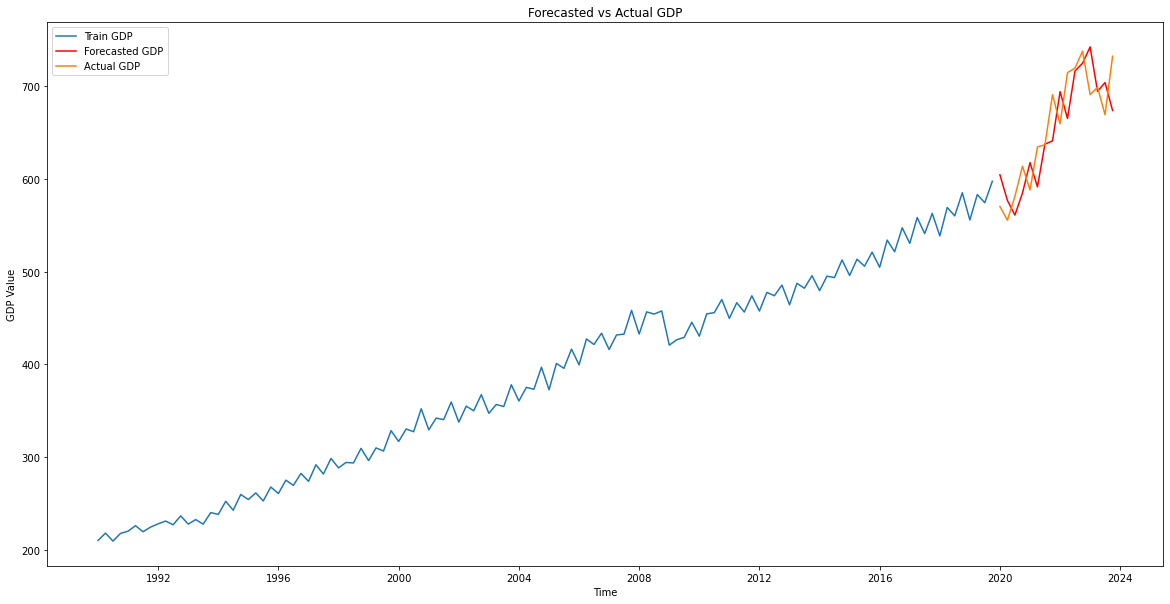

In [14]:
# Plotting the results against the actual values
plt.figure(figsize=(20,10))
plt.plot(gdp_train['Time'].to_numpy(), gdp_train['Value'].to_numpy(), label='Train GDP')
plt.plot(gdp_test['Time'].to_numpy(), y_preds, label='Forecasted GDP', color='red')
plt.plot(gdp_test['Time'].to_numpy(), gdp_test['Value'].to_numpy(), label='Actual GDP')
plt.xlabel('Time')
plt.ylabel('GDP Value')
plt.title('Forecasted vs Actual GDP')
plt.legend(loc='upper left')
plt.show()

